In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda


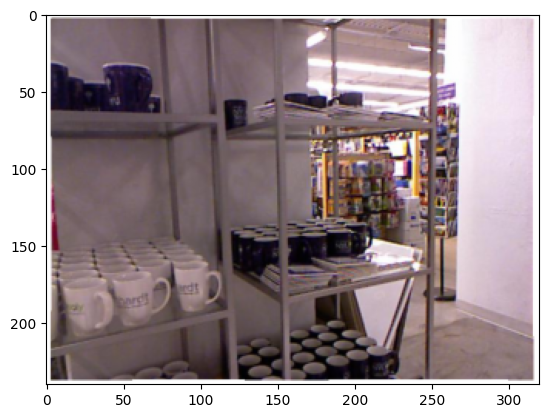

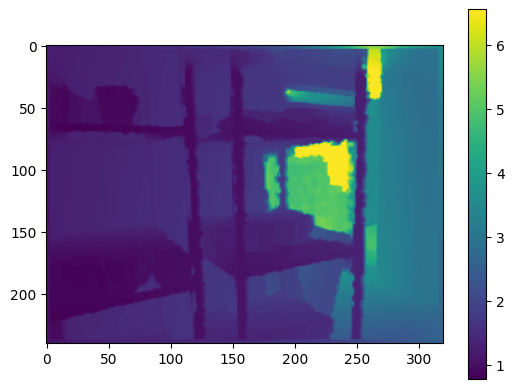

adaptive kernel size set to 11


In [2]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
gt_aif, gt_dpt = utils.load_single_sample(sample='0101', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018961847..1.0001811].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019168967..1.0001811].


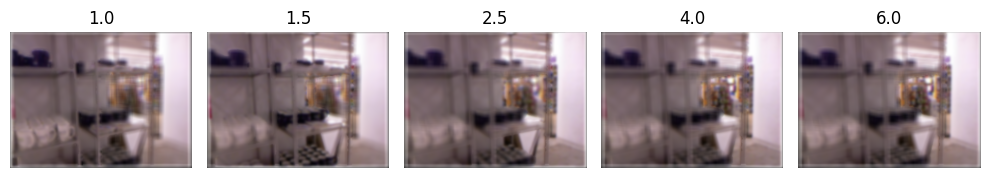

In [3]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



In [ ]:
k=3
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(gt_aif, defocus_stack_torch)

# k=1
# depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt(gt_aif, defocus_stack_torch)
# k_min_indices = np.expand_dims(k_min_indices, axis=-1)


In [ ]:
plt.imshow(depth_maps, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

In [ ]:
last_depth_map_golden = None
for kk in range(k):
    depth_map_golden = section_search.golden_section_search(Z, k_min_indices[:,:,kk], gt_aif, defocus_stack_torch,
                                                            window=1, tolerance=1e-6)
    plt.imshow(depth_map_golden, vmin = gt_dpt.min(), vmax = gt_dpt.max())
    plt.show()
    # chose which is better 
    if last_depth_map_golden is None:
        last_depth_map_golden = depth_map_golden
    else:
        mse = section_search.objective_full(depth_map_golden, gt_aif, defocus_stack_torch, gamma=0, similarity_penalty=False, last_dpt=None)
        last_mse = section_search.objective_full(last_depth_map_golden, gt_aif, defocus_stack_torch, gamma=0, similarity_penalty=False, last_dpt=None)
        last_depth_map_golden = np.where(mse <= last_mse, depth_map_golden, last_depth_map_golden)
        
        
if last_depth_map_golden is not None:
    depth_map_golden = last_depth_map_golden

plt.imshow(depth_map_golden, vmin = gt_dpt.min(), vmax = gt_dpt.max())
plt.show()

In [ ]:
# # AIF initialization

# # aif_init = initialization.trivial_aif_initialization(defocus_stack)
# aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
# plt.imshow(aif_init / IMAGE_RANGE)
# plt.show()

# plt.imshow(defocus_stack[1] / IMAGE_RANGE)
# plt.show()

In [4]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=40,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init,
                                                 aif_method='fista', finite_differences=False, num_Z=100,
                                                 ls_maxiter=200, ls_maxiter_multiplier=1.05,#1.075, 
                                                    k=3,
                                                 use_CUDA=False, vmin = gt_dpt.min(), vmax = gt_dpt.max())


Created experiment folder: experiments/coord-descent_2025-08-11_12-48-11
Images in range [0-255]
Iteration 0 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05392258]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 19 instead with accuracy 
0.050954603713657155.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0509546]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 10.597388744354248


Optimizing: 100%|█████████████████████████████| 200/200 [01:49<00:00,  1.82it/s]


r1norm 7547.869857247679 norm(x) 69690.48037676395

AIF result range: [ 0.0 , 255.0 ]
Loss: 49.453399658203125 , TV: 8557382.543552348
Loss after clipping: 49.453399658203125 , TV: 8557382.543552348



Grid search         : 100%|███████████████████| 100/100 [00:30<00:00,  3.25it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 10.312216348514855 , TV: 88134.8456794254

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 210


--------------------------

Iteration 1 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03426372]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.034263721885970884.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03426372]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.7952492237091064


Optimizing: 100%|█████████████████████████████| 210/210 [01:16<00:00,  2.76it/s]


r1norm 2331.4135390198126 norm(x) 69868.84880584813

AIF result range: [ 0.0 , 255.0 ]
Loss: 4.71828524100331 , TV: 10511617.458610136
Loss after clipping: 4.71828524100331 , TV: 10511617.458610136



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.35it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.942234428202419 , TV: 67514.49178165394

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 220


--------------------------

Iteration 2 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02900403]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.029004033428605875.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02900403]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.472468376159668


Optimizing: 100%|█████████████████████████████| 220/220 [01:18<00:00,  2.79it/s]


r1norm 1438.2389859306088 norm(x) 69312.77047581735

AIF result range: [ 0.0 , 255.0 ]
Loss: 1.7955891039047307 , TV: 8247950.762479369
Loss after clipping: 1.7955891039047307 , TV: 8247950.762479369



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.49it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.3622334565379175 , TV: 51367.53996467064

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 231


--------------------------

Iteration 3 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03741231]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0374123137125641.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03741231]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.570753812789917


Optimizing: 100%|█████████████████████████████| 231/231 [01:23<00:00,  2.78it/s]


r1norm 1076.9681116421625 norm(x) 69046.84251102599

AIF result range: [ 0.0 , 255.0 ]
Loss: 1.0068158657175688 , TV: 6908973.115459659
Loss after clipping: 1.0068158657175688 , TV: 6908973.115459659



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.31it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.8361767810874307 , TV: 42255.84211877256

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 242


--------------------------

Iteration 4 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04730578]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.047305781983153126.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04730578]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.871418476104736


Optimizing: 100%|█████████████████████████████| 242/242 [01:26<00:00,  2.79it/s]


r1norm 880.7668209995248 norm(x) 68902.41343590552

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.6733899087710822 , TV: 6192909.579119137
Loss after clipping: 0.6733899087710822 , TV: 6192909.579119137



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.32it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.5989165870112013 , TV: 36042.895317056165

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 254


--------------------------

Iteration 5 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03125656]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03125656481377889.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03125656]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.657655477523804


Optimizing: 100%|█████████████████████████████| 254/254 [01:30<00:00,  2.79it/s]


r1norm 769.4532982763192 norm(x) 68805.42136403536

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.5139360937538071 , TV: 5802850.576150294
Loss after clipping: 0.5139360937538071 , TV: 5802850.576150294



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.38it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.4656141750352278 , TV: 30817.89003750214

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 266


--------------------------

Iteration 6 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03208653]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03208653427592598.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03208653]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.562905788421631


Optimizing: 100%|█████████████████████████████| 266/266 [01:35<00:00,  2.78it/s]


r1norm 684.5248139147413 norm(x) 68735.45620575524

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.4067458698652203 , TV: 5534294.064668998
Loss after clipping: 0.4067458698652203 , TV: 5534294.064668998



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.53it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.3731949731709791 , TV: 27624.84166158308

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 279


--------------------------

Iteration 7 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05054461]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 16 instead with accuracy 
0.04197683512873214.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04197684]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.4927146434783936


Optimizing: 100%|█████████████████████████████| 279/279 [01:40<00:00,  2.77it/s]


r1norm 619.0690570322507 norm(x) 68706.36798896379

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.33267723491105716 , TV: 5382191.851975905
Loss after clipping: 0.33267723491105716 , TV: 5382191.851975905



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.46it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.3059503941688605 , TV: 24361.182881354714

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 292


--------------------------

Iteration 8 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04852878]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.048528780241532704.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04852878]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.6440112590789795


Optimizing: 100%|█████████████████████████████| 292/292 [01:44<00:00,  2.78it/s]


r1norm 563.0173175520885 norm(x) 68671.09250878345

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.27516206464578924 , TV: 5252026.469352812
Loss after clipping: 0.27516206464578924 , TV: 5252026.469352812



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.36it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.26173607347975303 , TV: 22788.304283690035

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 306


--------------------------

Iteration 9 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02963863]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.029638625487300896.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02963863]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.123822212219238


Optimizing: 100%|█████████████████████████████| 306/306 [01:50<00:00,  2.78it/s]


r1norm 527.5971904088398 norm(x) 68658.56946349732

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.24162960488228175 , TV: 5199259.110236751
Loss after clipping: 0.24162960488228175 , TV: 5199259.110236751



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.35it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.22352843732240374 , TV: 20986.584267705148

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 321


--------------------------

Iteration 10 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04516231]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.045162314312383975.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04516231]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.705913782119751


Optimizing: 100%|█████████████████████████████| 321/321 [01:57<00:00,  2.74it/s]


r1norm 483.6952275372892 norm(x) 68645.0135106629

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.20309017217939887 , TV: 5130691.171929365
Loss after clipping: 0.20309017217939887 , TV: 5130691.171929365



Grid search         : 100%|███████████████████| 100/100 [00:24<00:00,  4.16it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.19574636055693928 , TV: 19036.97390558509

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 337


--------------------------

Iteration 11 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0478851]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04788510478587954.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0478851]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.758717060089111


Optimizing: 100%|█████████████████████████████| 337/337 [02:01<00:00,  2.78it/s]


r1norm 464.9310854864347 norm(x) 68636.7527604054

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.18763879825533802 , TV: 5046756.86076534
Loss after clipping: 0.18763879825533802 , TV: 5046756.86076534



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.31it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1847529995892686 , TV: 17316.316454139873

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 353


--------------------------

Iteration 12 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03503071]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03503070855017411.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03503071]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.375277519226074


Optimizing: 100%|█████████████████████████████| 353/353 [02:08<00:00,  2.75it/s]


r1norm 454.8871887430743 norm(x) 68637.14475630812

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1796193268626768 , TV: 5034118.911857044
Loss after clipping: 0.1796193268626768 , TV: 5034118.911857044



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.21it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.17671824280782816 , TV: 16786.126208357317

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 370


--------------------------

Iteration 13 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03347881]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.033478811475163364.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03347881]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.919440746307373


Optimizing: 100%|█████████████████████████████| 370/370 [02:13<00:00,  2.77it/s]


r1norm 446.82258545206906 norm(x) 68641.5017377266

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.17330702819670107 , TV: 5028690.65569939
Loss after clipping: 0.17330702819670107 , TV: 5028690.65569939



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.33it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.17130408356366617 , TV: 16373.985247226597

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 388


--------------------------

Iteration 14 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03356596]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0335659610425651.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03356596]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.702943801879883


Optimizing: 100%|█████████████████████████████| 388/388 [02:20<00:00,  2.76it/s]


r1norm 438.7534110470776 norm(x) 68646.09225709063

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16710411043499693 , TV: 5038139.603628091
Loss after clipping: 0.16710411043499693 , TV: 5038139.603628091



Grid search         : 100%|███████████████████| 100/100 [00:23<00:00,  4.19it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.16533987497122699 , TV: 16215.817040649817

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 407


--------------------------

Iteration 15 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03221818]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.032218176149886604.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03221818]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.130063056945801


Optimizing: 100%|█████████████████████████████| 407/407 [02:34<00:00,  2.63it/s]


r1norm 432.0709539079333 norm(x) 68653.88481883566

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.16205271877497354 , TV: 5067140.960166593
Loss after clipping: 0.16205271877497354 , TV: 5067140.960166593



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.36it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.16074115560203445 , TV: 15903.690517644864

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 427


--------------------------

Iteration 16 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03790842]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03790841756681318.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03790842]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.5210959911346436


Optimizing: 100%|█████████████████████████████| 427/427 [02:39<00:00,  2.68it/s]


r1norm 427.56797969480476 norm(x) 68663.32640134246

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.15869260911604063 , TV: 5096110.198919788
Loss after clipping: 0.15869260911604063 , TV: 5096110.198919788



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.67it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15797293078637734 , TV: 15512.853656437579

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 448


--------------------------

Iteration 17 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05142701]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05142700971349171.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05142701]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.450786828994751


Optimizing: 100%|█████████████████████████████| 448/448 [02:46<00:00,  2.69it/s]


r1norm 424.9528823030892 norm(x) 68672.69222527051

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1567574677803414 , TV: 5125927.509948018
Loss after clipping: 0.1567574677803414 , TV: 5125927.509948018



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.50it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15618422485534994 , TV: 15326.801861811437

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 470


--------------------------

Iteration 18 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02827489]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.028274887916411525.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02827489]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.4041337966918945


Optimizing: 100%|█████████████████████████████| 470/470 [02:56<00:00,  2.66it/s]


r1norm 422.3117077244006 norm(x) 68681.78885714572

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.15481498622134665 , TV: 5173940.4311336735
Loss after clipping: 0.15481498622134665 , TV: 5173940.4311336735



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.69it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15453744901547234 , TV: 15214.44333613836

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 493


--------------------------

Iteration 19 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06131861]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.061318614141553235.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.06131861]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.806905031204224


Optimizing: 100%|█████████████████████████████| 493/493 [03:03<00:00,  2.69it/s]


r1norm 421.07190860470087 norm(x) 68695.13481906035

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1539073325545025 , TV: 5238061.543288192
Loss after clipping: 0.1539073325545025 , TV: 5238061.543288192



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.73it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1535723227551789 , TV: 15254.783609442027

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 517


--------------------------

Iteration 20 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04827676]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0482767620466902.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04827676]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.6915600299835205


Optimizing: 100%|█████████████████████████████| 517/517 [03:10<00:00,  2.71it/s]


r1norm 419.34312287592206 norm(x) 68708.27516928293

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.152646168188736 , TV: 5295322.177899189
Loss after clipping: 0.152646168188736 , TV: 5295322.177899189



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.86it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15225790956341978 , TV: 15212.277514301064

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 542


--------------------------

Iteration 21 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03950234]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.039502340956748476.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03950234]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.696380138397217


Optimizing: 100%|█████████████████████████████| 542/542 [03:25<00:00,  2.64it/s]


r1norm 417.80727157678643 norm(x) 68721.09813578072

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.15153010105693052 , TV: 5351519.354612082
Loss after clipping: 0.15153010105693052 , TV: 5351519.354612082



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.65it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15139004610000165 , TV: 15107.058299121149

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 569


--------------------------

Iteration 22 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05468785]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05468784804144324.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05468785]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.406857490539551


Optimizing: 100%|█████████████████████████████| 569/569 [03:33<00:00,  2.66it/s]


r1norm 417.19851016978424 norm(x) 68736.08108550093

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.15108888742561627 , TV: 5402614.819478011
Loss after clipping: 0.15108888742561627 , TV: 5402614.819478011



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.68it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1510341650595202 , TV: 14965.26137265217

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 597


--------------------------

Iteration 23 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05438728]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05438727641325896.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05438728]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.9105658531188965


Optimizing: 100%|█████████████████████████████| 597/597 [03:49<00:00,  2.61it/s]


r1norm 415.9951924066819 norm(x) 68748.4383913457

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.15021859308859264 , TV: 5462396.474700985
Loss after clipping: 0.15021859308859264 , TV: 5462396.474700985



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.55it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15003422602424618 , TV: 14855.658445748635

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 626


--------------------------

Iteration 24 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06476231]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 17 instead with accuracy 
0.05699214425130796.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05699214]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.240196943283081


Optimizing: 100%|█████████████████████████████| 626/626 [03:57<00:00,  2.64it/s]


r1norm 415.1413159217407 norm(x) 68765.65451986274

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.14960255846471515 , TV: 5537853.077254056
Loss after clipping: 0.14960255846471515 , TV: 5537853.077254056



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.80it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1495326099996548 , TV: 14836.379499786752

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 657


--------------------------

Iteration 25 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04542148]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04542147976662459.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04542148]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.348571300506592


Optimizing: 100%|█████████████████████████████| 657/657 [04:07<00:00,  2.66it/s]


r1norm 414.12363227062997 norm(x) 68783.68626610281

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.14886998859064218 , TV: 5616722.355318513
Loss after clipping: 0.14886998859064218 , TV: 5616722.355318513



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.50it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1487331224121925 , TV: 14813.964648817397

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 689


--------------------------

Iteration 26 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05518179]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05518179043293555.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05518179]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.201485633850098


Optimizing: 100%|█████████████████████████████| 689/689 [04:23<00:00,  2.62it/s]


r1norm 413.3423588872021 norm(x) 68798.52231457886

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1483088385372092 , TV: 5680955.60170322
Loss after clipping: 0.1483088385372092 , TV: 5680955.60170322



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.75it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1482227302084727 , TV: 14797.861467358576

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 723


--------------------------

Iteration 27 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05383798]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05383798105911044.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05383798]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 7.074674844741821


Optimizing: 100%|█████████████████████████████| 723/723 [04:35<00:00,  2.63it/s]


r1norm 412.94924144854957 norm(x) 68816.83386841607

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1480268674205843 , TV: 5761299.379471835
Loss after clipping: 0.1480268674205843 , TV: 5761299.379471835



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.59it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14786129029617656 , TV: 14795.878300324071

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 759


--------------------------

Iteration 28 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.07462208]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 13 instead with accuracy 
0.07029276481255463.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.07029276]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.028346300125122


Optimizing: 100%|█████████████████████████████| 759/759 [04:43<00:00,  2.68it/s]


r1norm 411.5222129372663 norm(x) 68832.4379840133

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1470055807364172 , TV: 5832513.134286631
Loss after clipping: 0.1470055807364172 , TV: 5832513.134286631



Grid search         : 100%|███████████████████| 100/100 [00:22<00:00,  4.50it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1468558712784854 , TV: 14880.95924811418

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 796


--------------------------

Iteration 29 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0367896]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03678960203153094.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0367896]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.685849189758301


Optimizing: 100%|█████████████████████████████| 796/796 [04:57<00:00,  2.68it/s]


r1norm 410.5381292735287 norm(x) 68843.67201101634

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1463033504902494 , TV: 5890009.542207975
Loss after clipping: 0.1463033504902494 , TV: 5890009.542207975



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.69it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14592878585628585 , TV: 14729.93328866594

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 835


--------------------------

Iteration 30 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03978926]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.039789262075507904.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03978926]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.566534996032715


Optimizing: 100%|█████████████████████████████| 835/835 [05:19<00:00,  2.62it/s]


r1norm 408.3779300149453 norm(x) 68861.08539561233

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.14476775821587098 , TV: 5962822.569660058
Loss after clipping: 0.14476775821587098 , TV: 5962822.569660058



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.88it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14440069571837566 , TV: 14691.30342123214

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 876


--------------------------

Iteration 31 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.05047959]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.05047959032301656.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05047959]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.1457836627960205


Optimizing: 100%|█████████████████████████████| 876/876 [05:30<00:00,  2.65it/s]


r1norm 406.9364729815048 norm(x) 68876.16051993507

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.14374758308563046 , TV: 6039666.310358726
Loss after clipping: 0.14374758308563046 , TV: 6039666.310358726



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.56it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14360531737824692 , TV: 14733.098040361012

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 919


--------------------------

Iteration 32 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03853999]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03853999392914956.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03853999]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.22404408454895


Optimizing: 100%|█████████████████████████████| 919/919 [05:39<00:00,  2.71it/s]


r1norm 406.5436009218712 norm(x) 68891.60156179461

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.14347017820132682 , TV: 6112610.979344765
Loss after clipping: 0.14347017820132682 , TV: 6112610.979344765



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.79it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14338419823473225 , TV: 14699.776939451935

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 964


--------------------------

Iteration 33 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03956625]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03956625160345078.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03956625]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.6310200691223145


Optimizing: 100%|█████████████████████████████| 964/964 [05:58<00:00,  2.69it/s]


r1norm 405.8266077426792 norm(x) 68905.97498207589

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1429645705855613 , TV: 6186204.487213468
Loss after clipping: 0.1429645705855613 , TV: 6186204.487213468



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.72it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1428298261451238 , TV: 14628.164353037359

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1012


--------------------------

Iteration 34 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06622263]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 17 instead with accuracy 
0.05339642385519897.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.05339642]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.438076972961426


Optimizing: 100%|███████████████████████████| 1012/1012 [06:13<00:00,  2.71it/s]


r1norm 404.95305572125585 norm(x) 68920.02312710238

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.14234976679848435 , TV: 6257969.549157558
Loss after clipping: 0.14234976679848435 , TV: 6257969.549157558



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.56it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1420910319873845 , TV: 14628.103274604651

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1062


--------------------------

Iteration 35 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.04115465]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.0411546480032028.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.04115465]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.339062929153442


Optimizing: 100%|███████████████████████████| 1062/1062 [06:23<00:00,  2.77it/s]


r1norm 402.43224131790686 norm(x) 68930.71468305516

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.1405830493781629 , TV: 6326148.929430455
Loss after clipping: 0.1405830493781629 , TV: 6326148.929430455



Grid search         : 100%|███████████████████| 100/100 [00:21<00:00,  4.60it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1400999222877826 , TV: 14641.882385465538

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1115


--------------------------

Iteration 36 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.0496335]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.04963350387025822.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.0496335]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.431010723114014


Optimizing: 100%|███████████████████████████| 1115/1115 [06:38<00:00,  2.80it/s]


r1norm 399.8525789393911 norm(x) 68936.52748039452

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.13878650508173673 , TV: 6373650.425698433
Loss after clipping: 0.13878650508173673 , TV: 6373650.425698433



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.82it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.13823613909119636 , TV: 14608.266309555203

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1170


--------------------------

Iteration 37 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.06182227]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 17 instead with accuracy 
0.06074571004072167.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.06074571]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.884514331817627


Optimizing: 100%|███████████████████████████| 1170/1170 [07:02<00:00,  2.77it/s]


r1norm 397.85452870337343 norm(x) 68954.99905031589

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.13740295497159216 , TV: 6455964.086422838
Loss after clipping: 0.13740295497159216 , TV: 6455964.086422838



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.89it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.13707710935179435 , TV: 14535.915889022586

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1228


--------------------------

Iteration 38 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.03502381]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.03502381182947473.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.03502381]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 5.615554094314575


Optimizing: 100%|███████████████████████████| 1228/1228 [07:24<00:00,  2.76it/s]


r1norm 396.248880571311 norm(x) 68967.59216075268

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.13629614146298544 , TV: 6528520.514027906
Loss after clipping: 0.13629614146298544 , TV: 6528520.514027906



Grid search         : 100%|███████████████████| 100/100 [00:20<00:00,  4.78it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.13577609119923464 , TV: 14523.663529279154

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1289


--------------------------

Iteration 39 

Bounded FISTA...


/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.02674826]
not reaching the requested tolerance 0.0011444091796875.
Use iteration 21 instead with accuracy 
0.02674825542674056.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/work/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.02674826]
not reaching the requested tolerance 0.0011444091796875.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


step size 6.084350347518921


Optimizing: 100%|███████████████████████████| 1289/1289 [07:15<00:00,  2.96it/s]


r1norm 394.1515965831725 norm(x) 68980.78508608877

AIF result range: [ 0.0 , 255.0 ]
Loss: 0.13485717358546268 , TV: 6616143.7083343025
Loss after clipping: 0.13485717358546268 , TV: 6616143.7083343025



Grid search         : 100%|███████████████████| 100/100 [00:16<00:00,  6.25it/s]


(240, 320, 3)
(240, 320, 3) (240, 320, 3)
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.13464576980978396 , TV: 14548.387328014776

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 1353


--------------------------



In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]